In [1]:
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import plotly.express as px

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.compose import ColumnTransformer
from sklearn.manifold import TSNE

from mypackage import dir

# Environment variables
modality = 'p'
project = 'australian'
data = dir.make_dir_line(modality, project) 
processed = data('processed')
models = data('models')
outputs = data('outputs')

# Función para cargar datos
def cargar_datos(table_name: str) -> pd.DataFrame:
    df = pd.read_parquet(processed / f'{table_name}.parquet.gzip')
    print(f'Loaded table: {table_name}')
    return df

# Función para cargar los datos en la base de datos
def cargar_en_db(df: pd.DataFrame, table_name: str) -> None:
    df.to_parquet(models/f'{table_name}.parquet.gzip', compression='gzip')
    print(f'Saved table: {table_name}')

def get_month(x): return dt.datetime(x.year, x.month, 1) 

def get_dates(df, col):
    
    year = df[col].dt.year
    month = df[col].dt.month
    day = df[col].dt.day
    
    return year, month, day

In [2]:
rfm = cargar_datos('rfm')
X = rfm.loc[:,['recency', 'frequency', 'monetary']]
X.head()

Loaded table: rfm


,recency,frequency,monetary
0,232,13,1076.8
1,83,19,1835.2
2,90,14,1196.8
3,8,18,1808.0
4,2,14,1128.0


In [3]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Define a range of k values to explore
k_range = range(3, 15)

# Create an empty list to store SSE values
sse_values = []

for k in k_range:
    # Initialize KMeans with k clusters and random state for reproducibility
    kmeans = KMeans(n_clusters=k, random_state=42)
    # Fit KMeans on the scaled data
    kmeans.fit(X_scaled)
    # Append the inertia (SSE) for each k value
    sse_values.append(kmeans.inertia_)

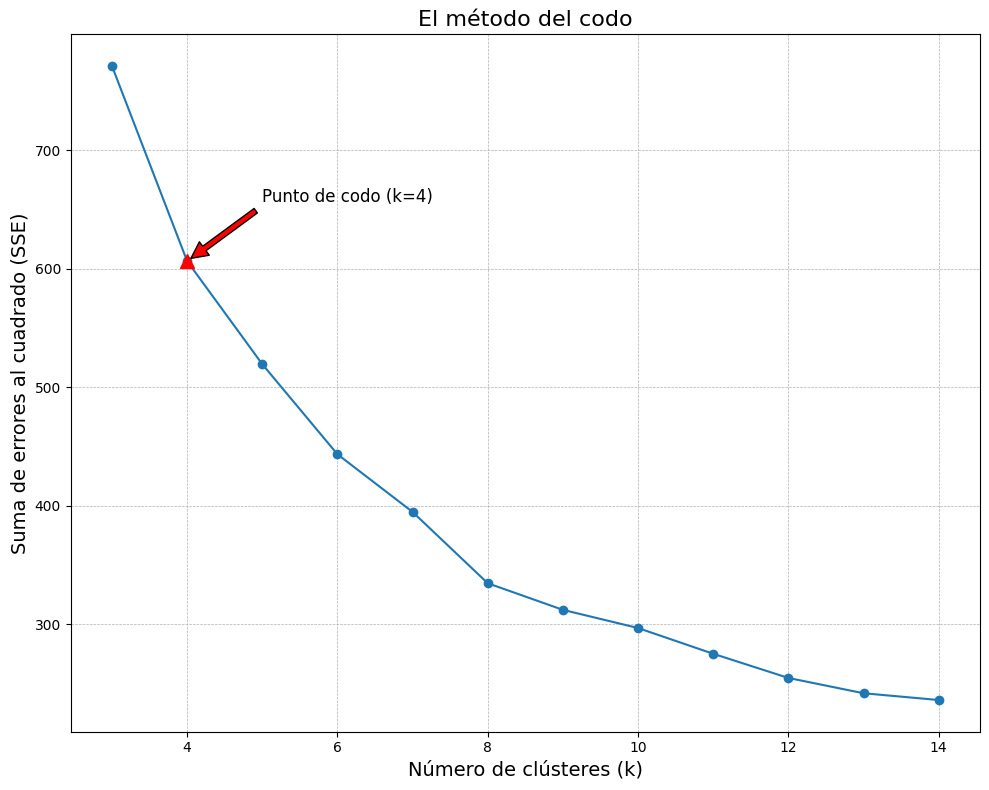

In [4]:
# Create the elbow method plot with clear labels and title
plt.figure(figsize=(10, 8))  # Set figure size for readability
plt.plot(k_range, sse_values, marker='o', linestyle='-')
plt.title('El método del codo', fontsize=16)
plt.xlabel('Número de clústeres (k)', fontsize=14)
plt.ylabel('Suma de errores al cuadrado (SSE)', fontsize=14)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)  # Add grid for better visualization
plt.tight_layout()  # Adjust spacing for readability
# Optionally, highlight the elbow point:
# Identify the index of the largest decrease in SSE (using differences)
differences = [abs(sse_values[i] - sse_values[i - 1]) for i in range(1, len(sse_values))]
elbow_point_index = differences.index(max(differences)) + 1
k_kmeans = k_range[elbow_point_index]

# Plot a marker (e.g., triangle) at the elbow point
plt.plot(k_range[elbow_point_index], sse_values[elbow_point_index], marker='^', markersize=10, color='red')
plt.annotate(f'Punto de codo (k={k_range[elbow_point_index]})',
             xy=(k_range[elbow_point_index], sse_values[elbow_point_index]),
             xytext=(k_range[elbow_point_index] + 1, sse_values[elbow_point_index] + 50),
             arrowprops=dict(facecolor='red', shrink=0.05), fontsize=12)
plt.savefig(outputs/'codo.png')
plt.show()

In [5]:
# Rango de componentes a evaluar
n_components = range(3, 11)

# Calcular BIC y AIC para cada número de componentes
models_gmm = [GaussianMixture(n_components=n, random_state=0).fit(X_scaled) for n in n_components]
bic = [model.bic(X_scaled) for model in models_gmm]
aic = [model.aic(X_scaled) for model in models_gmm]

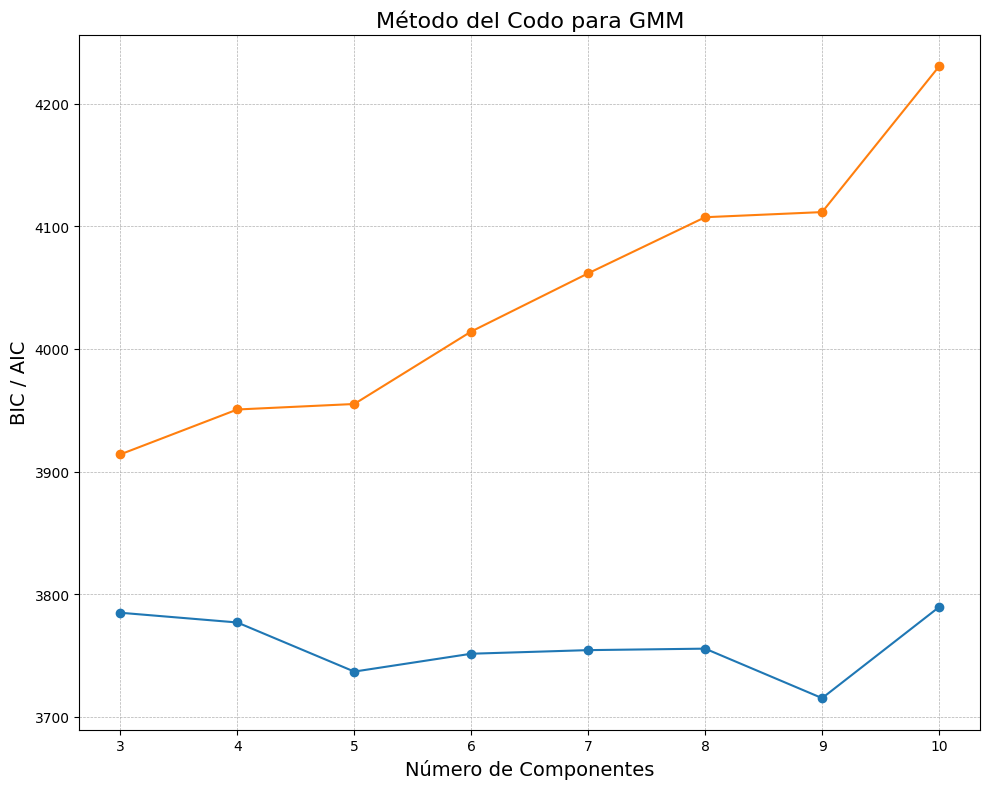

In [6]:
# Graficar el método del codo
plt.figure(figsize=(10, 8))  # Set figure size for readability
plt.plot(n_components, aic, marker='o', linestyle='-', label='AIC')
plt.plot(n_components, bic, marker='o', linestyle='-', label='BIC')
plt.xlabel('Número de Componentes', fontsize=14)
plt.ylabel('BIC / AIC', fontsize=14)
plt.title('Método del Codo para GMM', fontsize=16)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)  # Add grid for better visualization
plt.tight_layout()  # Adjust spacing for readability
# plt.legend()

# Optionally, highlight the elbow point:
# Identify the index of the largest decrease in SSE (using differences)
differences = [abs(aic[i] - aic[i - 1]) for i in range(1, len(aic))]
elbow_point_index = differences.index(max(differences)) #+ 1
k_gmm = k_range[elbow_point_index]

# # Plot a marker (e.g., triangle) at the elbow point
# plt.plot(k_range[elbow_point_index], aic[elbow_point_index + 1], marker='^', markersize=10, color='red')
# plt.annotate(f'Punto de codo (k={k_range[elbow_point_index]})',
#              xy=(k_range[elbow_point_index], aic[elbow_point_index + 1]),
#              xytext=(k_range[elbow_point_index] + 1, aic[elbow_point_index] + 50),
#              arrowprops=dict(facecolor='red', shrink=0.05), fontsize=12)
plt.show()

In [7]:
# Crear preprocesamiento (MinMaxScaler y StandardScaler)
preprocessor = ColumnTransformer(
    transformers=[
        ("minmax", MinMaxScaler(), slice(0, X.shape[1])),  # Escalado MinMax para todas las columnas
        ("std_scaler", StandardScaler(), slice(0, X.shape[1])),  # Estandarización
    ],
    remainder="passthrough"
)

# Crear modelos de clustering
kmeans = KMeans(n_clusters=k_kmeans, random_state=42)
gm = GaussianMixture(n_components=k_gmm, random_state=42)

# Pipelines
pipeline_kmeans = Pipeline(steps=[
    ('preprocessor', MinMaxScaler()),  # Escalado MinMax
    ('preprocessor2', StandardScaler()),  # Estandarización
    ('kmeans', kmeans)
])

pipeline_gmm = Pipeline(steps=[
    ('preprocessor', MinMaxScaler()),  # Escalado MinMax
    ('preprocessor2', StandardScaler()),  # Estandarización
    ('gmm', gm)
])

# Entrenamiento
pipeline_kmeans.fit(X)
pipeline_gmm.fit(X)

# Predicciones
rfm['labels_kmeans'] = pipeline_kmeans.predict(X)
rfm['labels_gmm'] = pipeline_gmm.predict(X)

In [8]:
cargar_en_db(rfm, 'segmentacion')

Saved table: segmentacion


In [9]:
tsne = TSNE(n_components=2, perplexity=10, learning_rate=50, random_state=42)
X_embedded = tsne.fit_transform(X_scaled)

df_tsne = pd.DataFrame(X_embedded, columns=['x', 'y'])
df_tsne['labels_kmeans'] = pipeline_kmeans.predict(X)
df_tsne['labels_gmm'] = pipeline_gmm.predict(X)

In [10]:
cargar_en_db(df_tsne, 'plot_tsne')

Saved table: plot_tsne


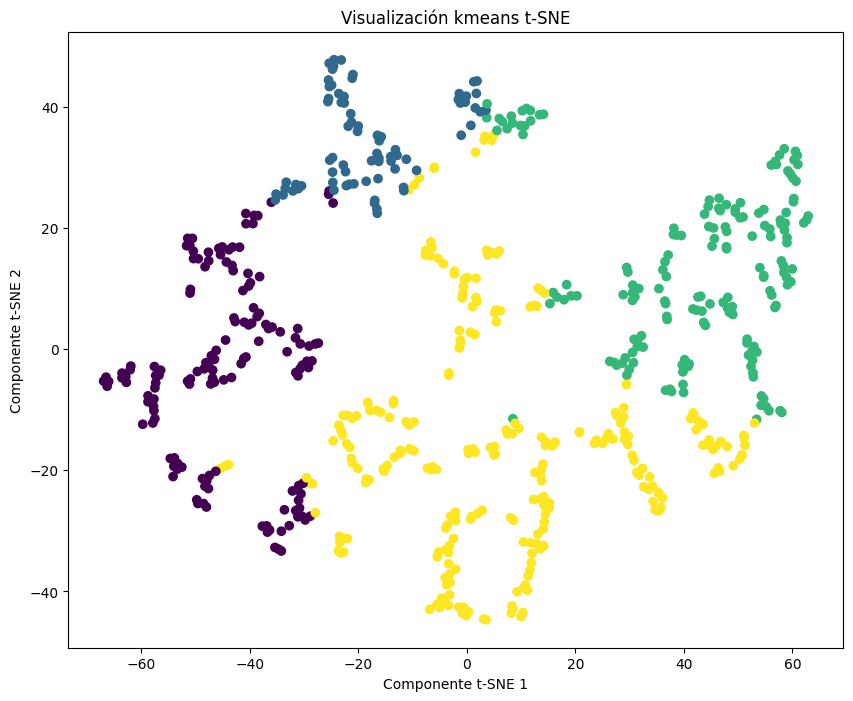

In [11]:
plt.figure(figsize=(10, 8))
plt.scatter(df_tsne['x'], df_tsne['y'], c=df_tsne['labels_kmeans'], cmap='viridis')
plt.xlabel('Componente t-SNE 1')
plt.ylabel('Componente t-SNE 2')
plt.title('Visualización kmeans t-SNE')
plt.savefig(outputs/'tsne-kmeans.png')
plt.show()

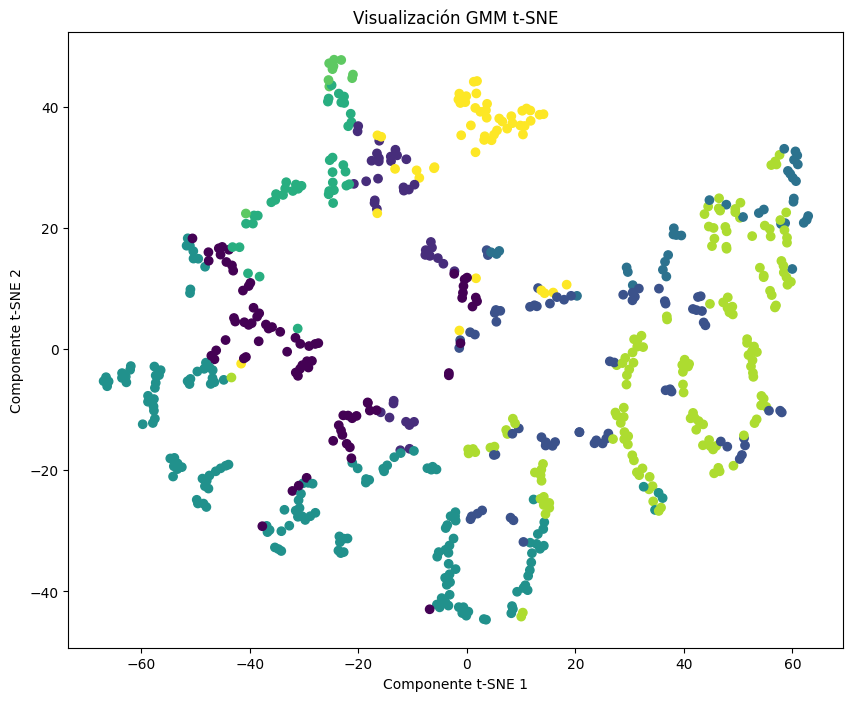

In [12]:
plt.figure(figsize=(10, 8))
plt.scatter(df_tsne['x'], df_tsne['y'], c=df_tsne['labels_gmm'], cmap='viridis')
plt.xlabel('Componente t-SNE 1')
plt.ylabel('Componente t-SNE 2')
plt.title('Visualización GMM t-SNE')
plt.savefig(outputs/'tsne-gmm.png')
plt.show()

# Grupos - descripciones

In [14]:
fig = px.box(rfm, y='recency', color='labels_kmeans', 
             title = 'Segmentation - kmeans',
             labels={'recency_t':'Recency', 
                     'frequency':'Frequency', 
                     'monetary':'Monetary', 
                     'group':'Group',
                     'labels_kmeans':'Group',
                     'segment':'Segment'
                    })
fig.show()

In [15]:
fig = px.box(rfm, y='recency', color='labels_kmeans', 
             title = 'Segmentation - kmeans',
             category_orders={'group': ['0','1','2','3','4','5','6','7','8']},
             color_discrete_map={'0':'#4AC3FF','1':'#684cf6','2':'#90dde0','3':'#447FF5','4':'#78e591','5':'#1e5274',
                                 '6':'#FFE343','7':'#9EFF43','8':'#4AC3FF'},
             labels={'recency_t':'Recency', 
                     'frequency':'Frequency', 
                     'monetary':'Monetary', 
                     'group':'Group',
                     'labels_kmeans':'Group',
                     'segment':'Segment'
                    })
fig.show()

In [16]:
fig = px.box(rfm, y='frequency', color='labels_kmeans', 
             title = 'Segmentation - kmeans',
             category_orders={'group': ['1','2','3','4','5','6','7','8']},
             color_discrete_map={'1':'#684cf6','2':'#90dde0','3':'#447FF5','4':'#78e591','5':'#1e5274',
                                 '6':'#FFE343','7':'#9EFF43','8':'#4AC3FF'},
             labels={'recency_t':'Recency', 
                     'frequency':'Frequency', 
                     'monetary':'Monetary', 
                     'group':'Group',
                     'segment':'Segment'
                    })
fig.show()

In [17]:
fig = px.box(rfm, y='monetary', color='labels_kmeans', 
             title = 'Segmentation - kmeans',
             category_orders={'group': ['1','2','3','4','5','6','7','8']},
             color_discrete_map={'1':'#684cf6','2':'#90dde0','3':'#447FF5','4':'#78e591','5':'#1e5274',
                                 '6':'#FFE343','7':'#9EFF43','8':'#4AC3FF'},
             labels={'recency_t':'Recency', 
                     'frequency':'Frequency', 
                     'monetary':'Monetary', 
                     'group':'Group',
                     'segment':'Segment'
                    })
fig.show()

In [18]:
fig = px.box(rfm, y='recency', color='labels_gmm', 
             title = 'Segmentation - kmeans',
             category_orders={'group': ['1','2','3','4','5','6','7','8']},
             color_discrete_map={'1':'#684cf6','2':'#90dde0','3':'#447FF5','4':'#78e591','5':'#1e5274',
                                 '6':'#FFE343','7':'#9EFF43','8':'#4AC3FF'},
             labels={'recency_t':'Recency', 
                     'frequency':'Frequency', 
                     'monetary':'Monetary', 
                     'group':'Group',
                     'segment':'Segment'
                    })
fig.show()

In [19]:
fig = px.box(rfm, y='frequency', color='labels_gmm', 
             title = 'Segmentation - kmeans',
             category_orders={'group': ['1','2','3','4','5','6','7','8']},
             color_discrete_map={'1':'#684cf6','2':'#90dde0','3':'#447FF5','4':'#78e591','5':'#1e5274',
                                 '6':'#FFE343','7':'#9EFF43','8':'#4AC3FF'},
             labels={'recency_t':'Recency', 
                     'frequency':'Frequency', 
                     'monetary':'Monetary', 
                     'group':'Group',
                     'segment':'Segment'
                    })
fig.show()

In [20]:
fig = px.box(rfm, y='monetary', color='labels_gmm', 
             title = 'Segmentation - kmeans',
             category_orders={'group': ['1','2','3','4','5','6','7','8']},
             color_discrete_map={'1':'#684cf6','2':'#90dde0','3':'#447FF5','4':'#78e591','5':'#1e5274',
                                 '6':'#FFE343','7':'#9EFF43','8':'#4AC3FF'},
             labels={'recency_t':'Recency', 
                     'frequency':'Frequency', 
                     'monetary':'Monetary', 
                     'group':'Group',
                     'segment':'Segment'
                    })
fig.show()

In [22]:
rfm.groupby(['labels_kmeans'], as_index=False).agg({'recency': ['count','mean', 'min', 'max'], 
                                                    'frequency': ['mean', 'min', 'max'],
                                                    'monetary': ['mean', 'min', 'max'],
                                                    })

labels_kmeans recency                        frequency             monetary  \
                  count        mean  min  max       mean min max         mean   
0             0     144   46.958333    2  201  11.069444   6  14   939.388889   
1             1      75  286.706667  162  754  13.173333   8  21  1149.482667   
2             2     167   47.820359    1  261  19.586826  15  28  1845.183234   
3             3     249   43.883534    1  182  15.522088  10  20  1363.797590   

                   
      min     max  
0   275.2  1299.2  
1   552.0  1820.8  
2  1297.6  2782.4  
3  1008.0  1796.8

In [38]:
df_normalizado  = rfm.copy()
df_normalizado[['recency', 'frequency', 'monetary']] = scaler.fit_transform(df_normalizado[['recency', 'frequency', 'monetary']])
df_normalizado.groupby(['labels_kmeans'], as_index=False).agg({'recency': ['mean'], 
                                                              'frequency': ['mean'],
                                                              'monetary': ['mean'],
                                                              })

,labels_kmeans,recency,frequency,monetary
,,mean,mean,mean
0,0,-0.277733,-1.158319,-1.108686
1,1,2.157952,-0.582813,-0.566303
2,2,-0.268976,1.171557,1.229736
3,3,-0.308971,0.059674,-0.013022


In [ ]:
rfm.groupby(['labels_gmm'], as_index=False).agg({'recency': ['count','mean', 'min', 'max'], 
                                                    'frequency': ['mean', 'min', 'max'],
                                                    'monetary': ['mean', 'min', 'max'],
                                                    })

In [24]:
print('Ok_')

Ok_
